In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Load the CSV file
csv_file = 'data/pokemon.csv'  # Update this to your CSV file path
data = pd.read_csv(csv_file)

# Check the columns in the DataFrame
print("Columns in the DataFrame:", data.columns)

# Directory containing the Pokémon images
image_directory = 'data/pokemon_images'  # Your images folder path
image_files = os.listdir(image_directory)

Columns in the DataFrame: Index(['label', 'Type1', 'Type2', 'Evolution', 'filename'], dtype='object')


In [3]:
# Populate the 'filename' column based on the labels
def find_image_filename(label):
    # Construct the expected filename (assuming images are named as 'label.jpg' or 'label.png')
    for img in image_files:
        if img.lower().startswith(label.lower()) and (img.endswith('.jpg') or img.endswith('.png')):
            return img
    return None  # Return None if no matching file is found

# Create a new column 'filename' in the DataFrame
data['filename'] = data['label'].apply(find_image_filename)

# Check the updated DataFrame
print(data.head())

        label  Type1   Type2   Evolution        filename
0   bulbasaur  Grass  Poison     ivysaur   bulbasaur.png
1     ivysaur  Grass  Poison    venusaur     ivysaur.png
2    venusaur  Grass  Poison         NaN    venusaur.png
3  charmander   Fire     NaN  charmeleon  charmander.png
4  charmeleon   Fire     NaN   charizard  charmeleon.png


In [27]:
# Load images and their corresponding labels
X = []
Y = []

for index, row in data.iterrows():
    img_path = os.path.join(image_directory, row['filename'])  # Construct the full image path
    image = cv2.imread(img_path)  # Read the image

    if image is not None:  # Check if the image was loaded successfully
        image = cv2.resize(image, (100, 100))  # Resize to the desired input size
        X.append(image)  # Append image to the list
        Y.append(row['label'])  # Adjust to your actual label column
    else:
        print(f"Warning: Unable to load image at path: {img_path}")

In [28]:
# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)


In [29]:
# Encode labels to integers
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)


In [9]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0


In [30]:
from keras.layers import Input

In [31]:
# Build the model using Input layer
model = Sequential([
    Input(shape=(100, 100, 3)),  # Use Input layer to specify the shape
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer for number of classes
])


In [32]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [33]:
# Train the model
model.fit(X_train, Y_train, epochs=10, batch_size=32)


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - accuracy: 0.0000e+00 - loss: 6.7320
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.0159 - loss: 6.6894
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.0090 - loss: 6.5905
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.1228 - loss: 6.0382
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.3873 - loss: 3.9627
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.7772 - loss: 1.1669
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.9569 - loss: 0.2414
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.9961 - loss: 0.0493
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.9918 - loss: 0.0425
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.9929 - loss: 0.0156


In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.0000e+00 - loss: 34.9016
Test Loss: 34.89778518676758, Test Accuracy: 0.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


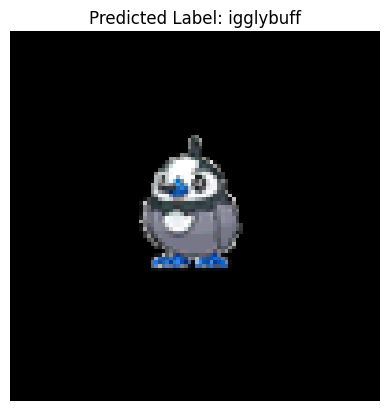

In [26]:
# Visualize a sample image and its predicted label
idx = np.random.randint(0, len(X_test))
plt.imshow(X_test[idx])
predicted_label = label_encoder.inverse_transform([model.predict(X_test[idx:idx+1]).argmax()])[0]
plt.title(f'Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()
    

In [17]:
# Save the updated DataFrame back to CSV if needed
data.to_csv(csv_file, index=False)  # This will overwrite the existing file


In [36]:
# Function to predict Pokémon image by name
def predict_pokemon_image(pokemon_name):
    # Load and preprocess the image
    img_path = os.path.join(image_directory, f"{pokemon_name}.png")  # Adjust the format if necessary
    image = cv2.imread(img_path)
    
    if image is None:
        print(f"No image found for {pokemon_name}.")
        return
    
    image_resized = cv2.resize(image, (100, 100))  # Resize to model input size
    image_array = np.array(image_resized) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    
# Make predictions
    prediction = model.predict(image_array)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_label = label_encoder.inverse_transform(predicted_class)[0]
    
    # Display the image and prediction
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


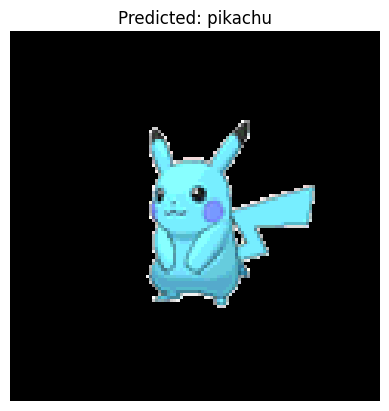

In [39]:
# Example usage
pokemon_name = "pikachu"  # Replace with any Pokémon name
predict_pokemon_image(pokemon_name)